In [2]:
import pandas as pd
import numpy as np
import gc
import requests
import sklearn
from datetime import datetime
from collections import defaultdict
from sklearn.utils import resample
import statistics
import time
import socks
import socket
from stem import Signal
from stem.control import Controller
from itertools import cycle
import seaborn as sns

In [2]:
def to_btc(n):
    formatted_n = n / 100000000
    return formatted_n

In [3]:
df = pd.read_csv('address_merge_tagged.csv')
df = df.drop(columns = ['Unnamed: 0'])

In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 27051996 entries, 0 to 27051995
Data columns (total 2 columns):
 #   Column   Dtype 
---  ------   ----- 
 0   address  object
 1   label    object
dtypes: object(2)
memory usage: 412.8+ MB


In [8]:
df.value_counts('label')

label
services       13510172
exchange       10220546
gambling        2665669
dw_market        347413
mixer            225445
mining_pool       78721
miner              4030
dtype: int64

In [4]:
df_bal = pd.DataFrame()

for label in df['label'].unique():
    class_subset = df[df['label'] == label]
    if(len(class_subset)>4030):
        class_downsampled = resample(class_subset, replace=False, n_samples=10000, random_state=42)
        df_bal = pd.concat([df_bal, class_downsampled])
    else:
        df_bal = pd.concat([df_bal, class_subset])

In [10]:
df_bal.value_counts('label')

label
dw_market      10000
exchange       10000
gambling       10000
mining_pool    10000
mixer          10000
services       10000
miner           4030
dtype: int64

## Feature extraction

In [11]:
df_bal.tail()

,address,label
3943039,13tao859JLuNBVmSCmnHDwey2pGmrN8Hrg,dw_market
3931438,1NckZLLPoy6h7pXAdjj82tPQDQZZbNMevn,dw_market
3932312,1MABXggjyRVtJzLkBEDQU8zbmmQnRd2fSh,dw_market
3716666,13GygNPqLARou1RBzZaU2QoBu4JXpoxCiN,dw_market
3791726,1676gDfYxnuotg8Hyf5qyjnEeFJhAPq697,dw_market


In [5]:
features = ['address',
            'n_transactions',
            'n_in_tx',   
            'n_out_tx',   
            'tx_ratio',   
            'Max_in_tx_size',
            'min_in_tx_size',  
            'avg_in_tx_size',  
            'Max_out_tx_size',  
            'min_out_tx_size',  
            'avg_out_tx_size',  
            'min_tx_interval',  
            'Max_tx_interval',  
            'avg_tx_interval',  
            'std_dev_tx_interval',   
            'tot_rec_btc',  
            'tot_sent_btc',   
            'actual_balance',    
            'min_sent_btc',  
            'Max_sent_btc',   
            'avg_sent_btc',   
            'std_dev_sent_btc',  
            'min_rec_btc',   
            'Max_rec_btc',   
            'avg_rec_btc',   
            'std_dev_rec_btc',  
            'min_daily_tx',  
            'Max_daily_tx',  
            'avg_daily_tx',  
            'std_dev_daily_tx',  
            'Max_fee', 
            'min_fee',  
            'avg_fee',  
            'std_dev_fee', 
            'n_reused_address_in',  
            'n_reused_address_out',
            'label']

In [5]:
#test tor

import time
import socket
import socks

from urllib.request import urlopen
from stem import Signal
from stem.control import Controller

controller = Controller.from_port(port=9051)

def connectTor():
    socks.setdefaultproxy(socks.PROXY_TYPE_SOCKS5, "127.0.0.1", 9050, True)
    socket.socket = socks.socksocket

def renewTor():
    controller.authenticate("TesiMazzarella123")
    controller.signal(Signal.NEWNYM)

for i in range(5):
    renewTor()
    connectTor()
    time.sleep(10)

b'185.220.101.64\n'


KeyboardInterrupt: 

## Start tor (cmd)
- Password generation: tor --hash-password your_password
- Password setup: Edit torrc file modifying 'HashedControlPassword' with previous command's output
- Tor start: tor.exe -f "C:\Users\alema\Desktop\Tor Browser\Browser\TorBrowser\Data\Tor\torrc"

In [6]:
controller = Controller.from_port(port=9051)

def connectTor():
    socks.setdefaultproxy(socks.PROXY_TYPE_SOCKS5, "127.0.0.1", 9050, True)
    socket.socket = socks.socksocket

def renewTor():
    controller.authenticate("your_password")
    controller.signal(Signal.NEWNYM)

In [14]:
df_bal.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 64030 entries, 212243 to 3791726
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   address  64030 non-null  object
 1   label    64030 non-null  object
dtypes: object(2)
memory usage: 1.5+ MB


In [9]:
from requests.exceptions import HTTPError


records = 0

for _, row in df_bal.iloc[len(df):len(df_bal)].iterrows():
    
    time.sleep(10)
    address = row['address']
    label = row['label']
    url = f"https://blockchain.info/rawaddr/{address}"  

    retries = 0
    delay = 1
    
    while retries < 5:
        renewTor()
        connectTor()
        try:
            response = requests.get(url)
            response.raise_for_status()  
            data = response.json()
            break
        except HTTPError as http_err:
            if response.status_code == 429:  # Too Many Requests
                time.sleep(delay)
                delay *= 2  
                retries += 1
            else:
                print(f"HTTP error occurred: {http_err}")
                break
        except Exception as err:
            print(f"Generic error: {err}")
            break
    
    records += 1
    transactions = data['txs']
    n_transactions = data['n_tx'] 
    tot_rec_btc = to_btc(data['total_received']) 
    tot_sent_btc = to_btc(data['total_sent'])
    actual_balance = to_btc(tot_rec_btc - tot_sent_btc)
    
    n_in_tx = 0 
    n_out_tx = 0 
    min_sent_btc = -1  
    Max_sent_btc = 0.0   
    min_rec_btc = -1  
    Max_rec_btc = 0     
    min_tx_interval = -1  
    Max_tx_interval = 0   
    Max_fee = 0  
    min_fee = -1  
    Max_in_tx_size = 0   
    min_in_tx_size = -1  
    Max_out_tx_size = 0  
    min_out_tx_size = -1  
    
    
    ins = []
    outs = []
    intervals = []
    fees = []
    tot_fees = 0
    tot_interval = 0
    curr_time  = 0
    prev_time = 0
    tot_tx_in = 0
    tot_tx_out = 0
    n_reused_address_in = 0
    n_reused_address_out = 0
    
    date_count = defaultdict(int)
    
    for tx in transactions:
        #Temporal distribution of transactions
        curr_time = int(tx['time'])
        date_only = datetime.utcfromtimestamp(curr_time).date()
        date_count[date_only] += 1
        
        if prev_time != 0:
            curr_interval = abs(prev_time - curr_time)
            intervals.append(curr_interval)
            tot_interval += curr_interval
            if(curr_interval > Max_tx_interval):
                Max_tx_interval = curr_interval
            if((curr_interval < min_tx_interval) | (min_tx_interval < 0)):
                min_tx_interval = curr_interval
        prev_time = curr_time
    
        #Value distribution of transactions
        val = to_btc(tx['result'])
        if val >= 0: #Incoming transaction
            n_in_tx += 1
            ins.append(val)
            if val > Max_rec_btc:
                Max_rec_btc = val
            if ((min_rec_btc < 0) | (val < min_rec_btc)):
                min_rec_btc = val
        else: #Outgoing transaction
            n_out_tx += 1
            val = abs(val)
            outs.append(val)
            if (val > Max_sent_btc):
                Max_sent_btc = val
            if ((min_sent_btc < 0) | (val < min_sent_btc)):
                min_sent_btc = val
        #Fees        
        fee = to_btc(tx['fee'])
        tot_fees += fee
        fees.append(fee)
        if(fee > Max_fee): Max_fee = fee
        if((min_fee < 0) | (fee < min_fee)): min_fee = fee
    
        #Reused addresses
        tx_ins = tx['inputs']
        tx_outs = tx['out']
        
        tot_reuse = 0
        for addr in tx_ins:
            try:
                if(addr['prev_out']['addr'] == address): tot_reuse += 1
            except KeyError as k:
                print(f"Unknown input address {address}")
        if (tot_reuse > 1): n_reused_address_in += 1
            
        tot_reuse = 0
        for addr in tx_outs:
            try:
                if(addr['addr'] == address): tot_reuse += 1
            except KeyError as k:
                print(f"Unknown output address {address}")
        if (tot_reuse > 1): n_reused_address_out += 1
    
        #Transaction size
        tx_ins_len = len(tx_ins)
        tx_outs_len = len(tx_outs)
        tot_tx_in += tx_ins_len
        tot_tx_out += tx_outs_len
        
        if (tx_ins_len > Max_in_tx_size): Max_in_tx_size = tx_ins_len
        if ((min_in_tx_size < 0) | ( tx_ins_len < min_in_tx_size)): min_in_tx_size = tx_ins_len
    
        if (tx_outs_len > Max_out_tx_size): Max_out_tx_size = tx_outs_len
        if ((min_out_tx_size < 0) | ( tx_outs_len < min_out_tx_size)): min_out_tx_size = tx_outs_len
    
    if n_out_tx != 0:
        avg_sent_btc = tot_sent_btc / n_out_tx
    if n_in_tx != 0:
        avg_rec_btc = tot_rec_btc / n_in_tx
        
    if(len(outs) > 1):
        std_dev_sent_btc = statistics.stdev(outs)
    else:
        std_dev_sent_btc = 0

    if(len(ins) > 1):
        std_dev_rec_btc = statistics.stdev(ins)
    else:
        std_dev_rec_btc = 0
        
    avg_tx_interval = tot_interval / n_transactions

    if(len(intervals) > 1):
        std_dev_tx_interval = statistics.stdev(intervals)
    else:
        std_dev_tx_interval = 0
        
    Max_daily_tx = max(date_count.values())  
    min_daily_tx = min(date_count.values())  
    avg_daily_tx = sum(date_count.values()) / len(date_count)
    if(len(date_count.values()) > 1):
        std_dev_daily_tx = statistics.stdev(date_count.values())
    else:
        std_dev_daily_tx = 0
        
    avg_fee = tot_fees / n_transactions

    if(len(fees) > 1):
        std_dev_fee = statistics.stdev(fees)
    else:
        std_dev_fee = 0
        
    avg_in_tx_size = tot_tx_in / n_transactions    
    avg_out_tx_size = tot_tx_out / n_transactions  
    if n_out_tx != 0:
        tx_ratio = n_in_tx / n_out_tx  
    
    
    del ins
    del outs
    del intervals
    del fees
    del date_count
    gc.collect()

    tmp = pd.DataFrame({
            'address': [address],
            'n_transactions': [n_transactions],
            'n_in_tx': [n_in_tx],   
            'n_out_tx': [n_out_tx],   
            'tx_ratio': [tx_ratio],   
            'Max_in_tx_size': [Max_in_tx_size],
            'min_in_tx_size': [min_in_tx_size],  
            'avg_in_tx_size': [avg_in_tx_size],  
            'Max_out_tx_size': [Max_out_tx_size],  
            'min_out_tx_size': [min_out_tx_size],  
            'avg_out_tx_size': [avg_out_tx_size],  
            'min_tx_interval': [min_tx_interval],  
            'Max_tx_interval': [Max_tx_interval],  
            'avg_tx_interval': [avg_tx_interval],  
            'std_dev_tx_interval': [std_dev_tx_interval],   
            'tot_rec_btc': [tot_rec_btc],  
            'tot_sent_btc': [tot_sent_btc],   
            'actual_balance': [actual_balance],    
            'min_sent_btc': [min_sent_btc],  
            'Max_sent_btc': [Max_sent_btc],   
            'avg_sent_btc': [avg_sent_btc],   
            'std_dev_sent_btc': [std_dev_sent_btc],  
            'min_rec_btc': [min_rec_btc],   
            'Max_rec_btc': [Max_rec_btc],   
            'avg_rec_btc': [avg_rec_btc],   
            'std_dev_rec_btc': [std_dev_rec_btc],  
            'min_daily_tx': [min_daily_tx],  
            'Max_daily_tx': [Max_daily_tx],  
            'avg_daily_tx': [avg_daily_tx],  
            'std_dev_daily_tx': [std_dev_daily_tx],  
            'Max_fee': [Max_fee], 
            'min_fee': [min_fee],  
            'avg_fee': [avg_fee],  
            'std_dev_fee': [std_dev_fee], 
            'n_reused_address_in': [n_reused_address_in],  
            'n_reused_address_out': [n_reused_address_out],
            'label': [label]})

    df = pd.concat([df, tmp], ignore_index=True)
    if(records % 50) == 0:
        df.to_csv('checkpoint.csv')
    del tmp

HTTP error occurred: 403 Client Error: Forbidden for url: https://blockchain.info/rawaddr/1Mo6NBtFXiErvw1uH1MC7K9Yv3qqRE9ZGu
HTTP error occurred: 403 Client Error: Forbidden for url: https://blockchain.info/rawaddr/1KjX9jC3MvdcCPrFcv7XrSFXAmsfFLyzwB
Unknown input address 1Ps8bVpxe12ViGPsZSjt3SPahHC8DoY2rx
Unknown output address 1Ps8bVpxe12ViGPsZSjt3SPahHC8DoY2rx
Unknown input address 1Ps8bVpxe12ViGPsZSjt3SPahHC8DoY2rx
Unknown output address 1Ps8bVpxe12ViGPsZSjt3SPahHC8DoY2rx
Unknown input address 1Ps8bVpxe12ViGPsZSjt3SPahHC8DoY2rx
Unknown output address 1Ps8bVpxe12ViGPsZSjt3SPahHC8DoY2rx
Unknown input address 1Ps8bVpxe12ViGPsZSjt3SPahHC8DoY2rx
Unknown output address 1Ps8bVpxe12ViGPsZSjt3SPahHC8DoY2rx
Unknown input address 1Ps8bVpxe12ViGPsZSjt3SPahHC8DoY2rx
Unknown output address 1Ps8bVpxe12ViGPsZSjt3SPahHC8DoY2rx
Unknown input address 1Ps8bVpxe12ViGPsZSjt3SPahHC8DoY2rx
Unknown output address 1Ps8bVpxe12ViGPsZSjt3SPahHC8DoY2rx
Unknown input address 1Ps8bVpxe12ViGPsZSjt3SPahHC8DoY2rx
Unk

In [10]:
df.to_csv('dataset.csv')

In [29]:
url = f"https://blockchain.info/rawaddr/1BsCue5TpugNeWs4RaTgM52omLhCgkFJRf"  

retries = 0
delay = 1
    
while retries < 5:
    renewTor()
    connectTor()
    try:
        response = requests.get(url)
        response.raise_for_status()  
        data = response.json()
        break
    except HTTPError as http_err:
        if response.status_code == 429:  # Too Many Requests
            time.sleep(delay)
            delay *= 2  
            retries += 1
        else:
            print(f"HTTP error occurred: {http_err}")
            break
    except Exception as err:
        print(f"Generic error: {err}")
        break

data

{'hash160': '772ffef14470e8a2720512e4077fb4cfd56d91d4',
 'address': '1BsCue5TpugNeWs4RaTgM52omLhCgkFJRf',
 'n_tx': 2,
 'n_unredeemed': 0,
 'total_received': 780,
 'total_sent': 780,
 'final_balance': 0,
 'txs': [{'hash': '0dbb4d9863229ec0b0ab1785b5110a90b2da92dc0f9dee02271436884bc88472',
   'ver': 1,
   'vin_sz': 29,
   'vout_sz': 1,
   'size': 4321,
   'weight': 17284,
   'fee': 100000,
   'relayed_by': '0.0.0.0',
   'lock_time': 0,
   'tx_index': 4029267892569794,
   'double_spend': False,
   'time': 1416182306,
   'block_index': 330340,
   'block_height': 330340,
   'inputs': [{'sequence': 4294967295,
     'witness': '',
     'script': '47304402205a9b49ba9208eea437a1a74bfbf65551c061f3e6b4581d518c69bf6b603f61bb02206bfb6b1b22daee6d849bc9cfbcc542c6bf67da7d44f6ee1f9e6368249499fb67012102de9fa64da6b38f8824e7f3403dae8f9bbe4148e20d8d1165b5c388838a66e236',
     'index': 0,
     'prev_out': {'type': 0,
      'spent': True,
      'value': 63427,
      'spending_outpoints': [{'tx_index': 402926

In [3]:
df = pd.read_csv("dataset.csv").drop(columns=['Unnamed: 0', 'address', 'label'])  # Sostituisci con il tuo dataset
import matplotlib.pyplot as plt
eps = 1
df['n_reused_address_in'] = np.log(df['n_reused_address_in']  + eps)  
df['n_reused_address_out'] = np.log(df['n_reused_address_out'] + eps)
df['min_daily_tx'] = np.log(df['min_daily_tx'] + eps)  
df['Max_daily_tx'] =np.log(df['Max_daily_tx'] + eps)
df['avg_daily_tx'] =np.log(df['avg_daily_tx'] + eps)
df['Max_in_tx_size'] =np.log(df['Max_in_tx_size'] + eps)
df['min_in_tx_size'] =np.log(df['min_in_tx_size'] + eps)  
df['avg_in_tx_size'] =np.log(df['avg_in_tx_size'] + eps)  
df['Max_out_tx_size'] =np.log(df['Max_out_tx_size'] + eps)  
df['min_out_tx_size'] =np.log(df['min_out_tx_size'] + eps)  
df['avg_out_tx_size'] = np.log(df['avg_out_tx_size'] + eps) 
df['n_transactions'] = np.log(df['n_transactions'] + eps)
df['n_in_tx'] = np.log(df['n_in_tx'] + eps)  
df['n_out_tx'] = np.log(df['n_out_tx'] + eps)  
# Calcolare la matrice di correlazione di Pearson
corr_matrix = df.corr(method='pearson')


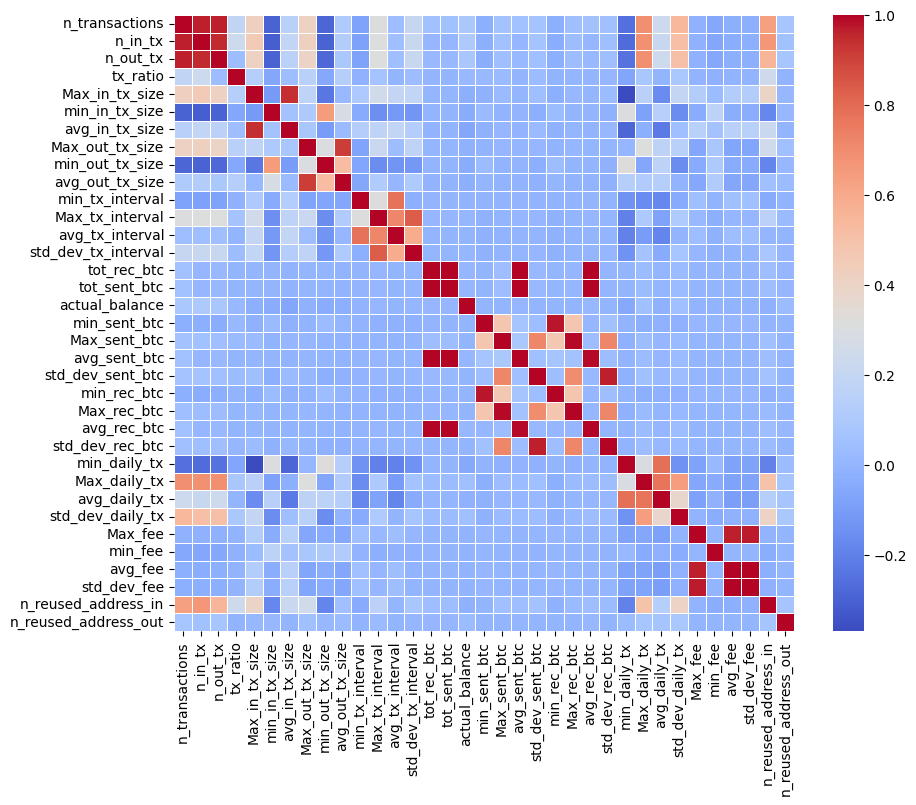

In [5]:
# Creare una heatmap per visualizzare la matrice di correlazione
plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=False, cmap="coolwarm", linewidths=0.5)
plt.savefig('correlation.pdf', format='pdf', dpi=1000, bbox_inches='tight')
plt.show()